In [1]:
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt

def find_tci_image(satellite_folder):
    """
    Find the TCI image within the given satellite folder.
    """
    granule_folder = os.path.join(satellite_folder, 'GRANULE')
    granule_subfolders = [os.path.join(granule_folder, d) for d in os.listdir(granule_folder) if os.path.isdir(os.path.join(granule_folder, d))]
    if len(granule_subfolders) == 0:
        print(f"No granule folder found in {granule_folder}")
        return None
    # Assuming only one granule folder
    granule_subfolder = granule_subfolders[0]
    img_data_folder = os.path.join(granule_subfolder, 'IMG_DATA')
    # Now search for files with 'TCI' in their name
    tci_files = glob.glob(os.path.join(img_data_folder, '*TCI*.jp2'))
    if len(tci_files) == 0:
        print(f"No TCI image found in {img_data_folder}")
        return None
    # Assuming only one TCI image
    tci_image_path = tci_files[0]
    return tci_image_path

def load_image(image_path):
    """
    Load the image from the given path.
    """
    # OpenCV uses BGR format by default
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if image is None:
        print(f"Failed to load image {image_path}")
    else:
        print(f"Loaded image {image_path}, shape: {image.shape}, dtype: {image.dtype}")
    return image

def preprocess_image(image):
    """
    Preprocess the image by normalizing if necessary.
    """
    # Normalize 16-bit images to 8-bit
    if image.dtype == np.uint16:
        image = (image / 256).astype('uint8')
    elif image.dtype != np.uint8:
        print(f"Unexpected image dtype: {image.dtype}")
    return image

def resize_image(image, scale_percent=50):
    """
    Resize the image to reduce computational load.
    """
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    return resized

def apply_clahe(image_gray):
    """
    Apply CLAHE to improve local contrast.
    """
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    image_clahe = clahe.apply(image_gray)
    return image_clahe




In [2]:
# Paths to the satellite image folders
sat_folder1 = '/kaggle/input/deforestation-in-ukraine/S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510/S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510.SAFE'
sat_folder2 = '/kaggle/input/deforestation-in-ukraine/S2A_MSIL1C_20160330T082542_N0201_R021_T36UYA_20160330T082810/S2A_MSIL1C_20160330T082542_N0201_R021_T36UYA_20160330T082810.SAFE'
# Find the TCI images
tci_image_path1 = find_tci_image(sat_folder1)
tci_image_path2 = find_tci_image(sat_folder2)

# Load the images
image1 = load_image(tci_image_path1)
image2 = load_image(tci_image_path2)



Loaded image /kaggle/input/deforestation-in-ukraine/S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510/S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510.SAFE/GRANULE/L1C_T36UYA_A003350_20160212T084510/IMG_DATA/T36UYA_20160212T084052_TCI.jp2, shape: (10980, 10980, 3), dtype: uint8
Loaded image /kaggle/input/deforestation-in-ukraine/S2A_MSIL1C_20160330T082542_N0201_R021_T36UYA_20160330T082810/S2A_MSIL1C_20160330T082542_N0201_R021_T36UYA_20160330T082810.SAFE/GRANULE/L1C_T36UYA_A004022_20160330T082810/IMG_DATA/T36UYA_20160330T082542_TCI.jp2, shape: (10980, 10980, 3), dtype: uint8


In [3]:
# Preprocess the images
image1 = preprocess_image(image1)
image2 = preprocess_image(image2)



In [4]:
# Resize the images if they are too large
image1_resized = resize_image(image1, scale_percent=50)
image2_resized = resize_image(image2, scale_percent=50)

# Convert to grayscale
gray1 = cv2.cvtColor(image1_resized, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2_resized, cv2.COLOR_BGR2GRAY)



In [5]:
# Apply CLAHE to improve contrast
gray1_clahe = apply_clahe(gray1)
gray2_clahe = apply_clahe(gray2)



In [6]:
# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
keypoints1, descriptors1 = sift.detectAndCompute(gray1_clahe, None)
keypoints2, descriptors2 = sift.detectAndCompute(gray2_clahe, None)



In [7]:
# Initialize BFMatcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

# Match descriptors using KNN
matches = bf.knnMatch(descriptors1, descriptors2, k=2)




In [8]:
# Apply ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

print(f"Number of good matches: {len(good_matches)}")


Number of good matches: 1183


In [9]:
# Extract location of good matches
points1 = np.zeros((len(good_matches), 2), dtype=np.float32)
points2 = np.zeros((len(good_matches), 2), dtype=np.float32)

for i, match in enumerate(good_matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

In [10]:
# Find homography matrix using RANSAC
H, mask = cv2.findHomography(points1, points2, cv2.RANSAC, 5.0)

matchesMask = mask.ravel().tolist()


In [11]:
# Draw matches
draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=None,
                   matchesMask=matchesMask,
                   flags=2)

matched_image = cv2.drawMatches(image1_resized, keypoints1, image2_resized, keypoints2, good_matches, None, **draw_params)


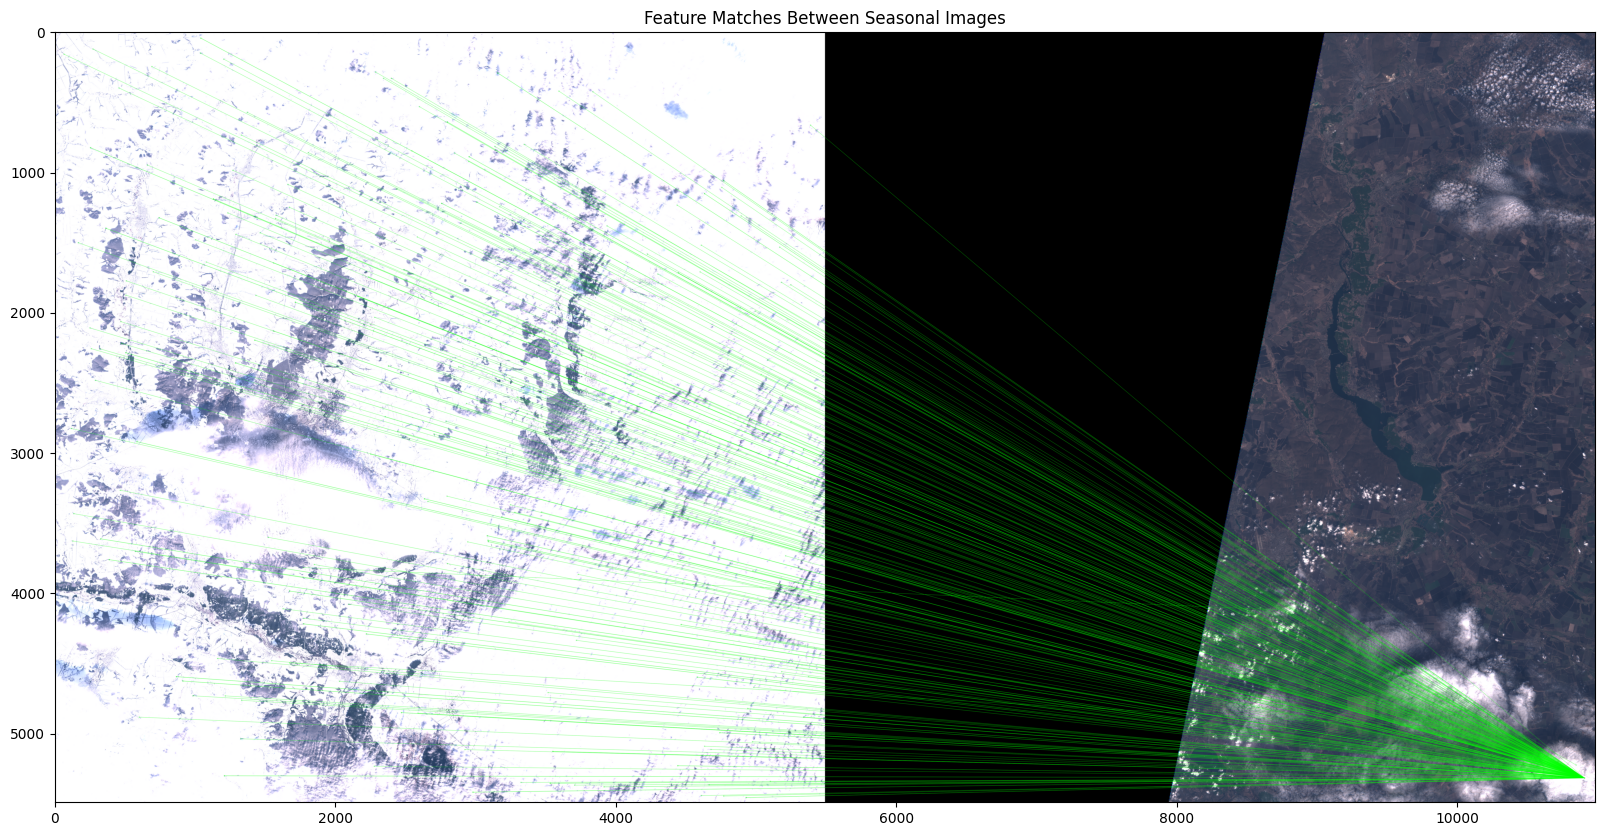

In [12]:

# Convert BGR to RGB for display
matched_image_rgb = cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(20, 10))
plt.imshow(matched_image_rgb)
plt.title('Feature Matches Between Seasonal Images')
plt.show()

## As it was expected, seasonal images mathes are not so good with claasical CV methods